In [ ]:
#avoids the need for users to install TD2C as a package
import sys
sys.path.append('../../') 

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
)

# --- Import plotting libraries ---
# You may need to install these: pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# --- 1. SCRIPT CONFIGURATION ---
# ==============================================================================

THRESHOLD = 0.309

# Directory where your 'causal_dfs_*.pkl' files are located
DATA_DIR = Path('../../data/causal_dfs/')

# Directories for outputs
output_dir = 'REAL_analysis'
tables_dir = f'{output_dir}/tables/'
figures_dir = f'{output_dir}/figures/'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

# List of all dataset files to process
FILES_TO_PROCESS = [
    'causal_dfs_DREAM3_10.pkl',
    'causal_dfs_DREAM3_50.pkl',
    'causal_dfs_NETSIM_5.pkl',
    'causal_dfs_NETSIM_10.pkl',
]

# Mapping from the tuple index in the pickle file to the method name
TUPLE_INDEX_TO_METHOD = [
    'VAR', 'VARLiNGAM', 'PCMCI', 'MVGC', 'PCMCI-GPDC',
    'GRANGER', 'DYNOTEARS', 'D2C'
]

# Define the final order of columns for the macro-averaged table
METRIC_ORDER = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1-Score"]

# Define which metrics to visualize in the summary boxplot
METRICS_FOR_SUMMARY_PLOT = ["F1-Score", "Precision", "Recall", "Balanced Accuracy"]

# ==============================================================================
# --- 2. MAIN PROCESSING LOOP ---
# ==============================================================================

# This list will store the per-run scores from ALL datasets for the final summary plot
all_macro_scores_list = []

for file_name in FILES_TO_PROCESS:
    input_path = DATA_DIR / file_name
    dataset_name_base = file_name.replace('causal_dfs_', '').replace('.pkl', '')
    
    print("\n" + "=" * 60)
    print(f"--- PROCESSING DATASET: {dataset_name_base.upper()} ---")
    
    # Load Data
    try:
        with open(input_path, 'rb') as f: loaded_data = pickle.load(f)
    except FileNotFoundError:
        print(f"WARNING: File not found, skipping: {input_path}\n")
        continue

    method_results_tuple, true_causal_dfs_dict = loaded_data[:-1], loaded_data[-1]

    # --- 2.1. MICRO-AVERAGING (POOLED) ---
    print("\n--- 1. MICRO-AVERAGING (POOLED) RESULTS TABLE ---")
    pooled_method_dfs = {}
    for i, method_dfs_dict in enumerate(method_results_tuple):
        method_name = TUPLE_INDEX_TO_METHOD[i]
        if method_dfs_dict is None or not method_dfs_dict: continue
        pooled_method_dfs[method_name] = pd.concat(method_dfs_dict.values()).reset_index(drop=True)

    y_true_df = pd.concat(true_causal_dfs_dict.values()).reset_index(drop=True)
    y_true = y_true_df['is_causal'].astype(int)

    micro_scores_data = []
    for method_name, pred_df in pooled_method_dfs.items():

        if method_name == 'D2C':
            y_proba = pred_df['probability'].astype(float)
            y_pred = (y_proba > THRESHOLD).astype(int)
        else:
            y_pred = pred_df['is_causal'].astype(int)

        micro_scores_data.append({
            "Method": method_name, "Accuracy": accuracy_score(y_true, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        })

    micro_scores_df = pd.DataFrame(micro_scores_data).set_index("Method")
    micro_output_path = tables_dir + f'summary_micro_{dataset_name_base}.csv'
    micro_scores_df.to_csv(micro_output_path, float_format="%.4f")
    print(micro_scores_df.to_string(float_format="%.4f"))
    print(f"Micro-Averaging table saved to {micro_output_path}\n")
    
    # --- 2.2. MACRO-AVERAGING (PER-RUN) & DATA COLLECTION ---
    print("\n--- 2. MACRO-AVERAGING (PER-RUN) RESULTS TABLE & BOXPLOTS ---")
    macro_results_list = []
    run_ids = sorted(true_causal_dfs_dict.keys())

    for run_id in run_ids:
        y_true_run = true_causal_dfs_dict[run_id]['is_causal'].astype(int)
        for i, method_dfs_dict in enumerate(method_results_tuple):
            method_name = TUPLE_INDEX_TO_METHOD[i]
            if method_dfs_dict is None or run_id not in method_dfs_dict: continue

            if method_name == 'D2C':
                y_proba_run = method_dfs_dict[run_id]['probability'].astype(float)
                y_pred_run = (y_proba_run > THRESHOLD).astype(int)
            else:
                y_pred_run = method_dfs_dict[run_id]['is_causal'].astype(int)
                
            # Create a dictionary of scores for this single run
            run_scores = {
                "Method": method_name, "Run ID": run_id, "Test Set": dataset_name_base,
                "Accuracy": accuracy_score(y_true_run, y_pred_run),
                "Balanced Accuracy": balanced_accuracy_score(y_true_run, y_pred_run),
                "Precision": precision_score(y_true_run, y_pred_run, zero_division=np.nan),
                "Recall": recall_score(y_true_run, y_pred_run, zero_division=np.nan),
                "F1-Score": f1_score(y_true_run, y_pred_run, zero_division=np.nan),
            }
            macro_results_list.append(run_scores)
            all_macro_scores_list.append(run_scores) # Add to the master list
    
    macro_scores_per_run_df = pd.DataFrame(macro_results_list)

    macro_summary = macro_scores_per_run_df.drop(columns=['Run ID', 'Test Set']).groupby('Method').agg(['mean', 'std']).fillna(0)
    formatted_macro_df = pd.DataFrame(index=macro_summary.index)
    for metric in METRIC_ORDER:
        if (metric, 'mean') in macro_summary.columns:
            mean_col, std_col = macro_summary[(metric, 'mean')], macro_summary[(metric, 'std')]
            formatted_macro_df[metric] = mean_col.map('{:.4f}'.format) + ' ± ' + std_col.map('{:.4f}'.format)
    
    macro_output_path = tables_dir + f'summary_macro_{dataset_name_base}.csv'
    formatted_macro_df.to_csv(macro_output_path)
    print(formatted_macro_df.to_string())
    print(f"Macro-Averaging table saved to {macro_output_path}")

# ==============================================================================
# --- 3. FINAL SUMMARY VISUALIZATION (NEW SECTION) ---
# ==============================================================================
print("\n" + "=" * 60)
print("--- GENERATING FINAL SUMMARY PLOTS ACROSS ALL DATASETS ---")

if not all_macro_scores_list:
    print("No data was collected. Skipping summary plot generation.")
else:
    # Create the master DataFrame from all collected runs
    master_df = pd.DataFrame(all_macro_scores_list)

    # Unpivot the DataFrame from wide to long format for easier plotting
    long_master_df = master_df.melt(
        id_vars=['Method', 'Test Set', 'Run ID'],
        value_vars=METRICS_FOR_SUMMARY_PLOT,
        var_name='Metric',
        value_name='Score'
    )

    # --- Create a plot for each metric ---
    for metric in METRICS_FOR_SUMMARY_PLOT:
        print(f"Generating summary plot for: {metric}")
        
        # Filter the data for the current metric
        metric_df = long_master_df[long_master_df['Metric'] == metric]

        # replace 'D2C' with 'TD2C'
        metric_df['Method'] = metric_df['Method'].replace('D2C', 'TD2C')

        # --- Create the Plot ---
        plt.style.use('seaborn-v0_8-talk') # A style with larger fonts for readability
        plt.figure(figsize=(18, 10)) # A wider figure to accommodate all data

        ax = sns.boxplot(
            data=metric_df,
            x='Test Set',      # The main grouping on the x-axis
            y='Score',         # The values to plot
            hue='Method',      # The nested grouping that creates different colored boxes
            palette='Set2'     # A professional, colorblind-friendly palette
        )

        # --- Polish and Style the Plot ---
        plt.xlabel('Dataset', fontsize=16, labelpad=15)
        plt.ylabel(metric, fontsize=16, labelpad=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim(-0.05, 1.05) # Set y-axis limits for consistency
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Puts grid lines behind the bars

        # Move the legend outside the plot area for clarity
        plt.legend(
            title='Method',
            loc='upper right',  # or 'upper left', 'lower right', 'lower left', etc.
            fontsize=12,
            title_fontsize=14
        )
        
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the legend

        # --- Save the Figure ---
        summary_plot_path = figures_dir + f'summary_boxplot_all_datasets_{metric}.png'
        plt.savefig(summary_plot_path, dpi=300) # High resolution for publications
        plt.close('all') # Close the figure to free up memory
        
        print(f"  > Saved plot to: {summary_plot_path}")

print("\n" + "=" * 60)
print("--- All benchmark evaluations and visualizations completed successfully! ---")


--- PROCESSING DATASET: DREAM3_10 ---

--- 1. MICRO-AVERAGING (POOLED) RESULTS TABLE ---
            Accuracy  Balanced Accuracy  Precision  Recall  F1-Score
Method                                                              
VAR           0.8633             0.5042     0.1000  0.0677    0.0807
VARLiNGAM     0.2160             0.5088     0.0903  0.8647    0.1636
PCMCI         0.8840             0.6445     0.3481  0.3534    0.3507
MVGC          0.8560             0.5172     0.1261  0.1053    0.1148
PCMCI-GPDC    0.8453             0.6131     0.2353  0.3308    0.2750
GRANGER       0.8213             0.4913     0.0755  0.0902    0.0822
DYNOTEARS     0.8800             0.5473     0.2235  0.1429    0.1743
D2C           0.8267             0.6979     0.2657  0.5414    0.3564
Micro-Averaging table saved to REAL_analysis/tables/summary_micro_DREAM3_10.csv


--- 2. MACRO-AVERAGING (PER-RUN) RESULTS TABLE & BOXPLOTS ---
                   Accuracy Balanced Accuracy        Precision           Rec

C:\Users\gmpal\AppData\Local\Temp\ipykernel_42360\2695585681.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_df['Method'] = metric_df['Method'].replace('D2C', 'TD2C')


  > Saved plot to: REAL_analysis/figures/summary_boxplot_all_datasets_F1-Score.png
Generating summary plot for: Precision


C:\Users\gmpal\AppData\Local\Temp\ipykernel_42360\2695585681.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_df['Method'] = metric_df['Method'].replace('D2C', 'TD2C')


  > Saved plot to: REAL_analysis/figures/summary_boxplot_all_datasets_Precision.png
Generating summary plot for: Recall


C:\Users\gmpal\AppData\Local\Temp\ipykernel_42360\2695585681.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_df['Method'] = metric_df['Method'].replace('D2C', 'TD2C')


  > Saved plot to: REAL_analysis/figures/summary_boxplot_all_datasets_Recall.png
Generating summary plot for: Balanced Accuracy


C:\Users\gmpal\AppData\Local\Temp\ipykernel_42360\2695585681.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_df['Method'] = metric_df['Method'].replace('D2C', 'TD2C')


  > Saved plot to: REAL_analysis/figures/summary_boxplot_all_datasets_Balanced Accuracy.png

--- All benchmark evaluations and visualizations completed successfully! ---


In [3]:
import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# --- CONFIGURATION FOR POSTER PLOT ---
# ==============================================================================

THRESHOLD = 0.309

# Directory where your 'causal_dfs_*.pkl' files are located
DATA_DIR = Path('../../data/causal_dfs/')

# Output directory for the poster figure
output_dir = 'POSTER_analysis'
figures_dir = f'{output_dir}/figures/'
os.makedirs(figures_dir, exist_ok=True)

# Only process the two datasets needed for the poster
FILES_TO_PROCESS = [
    'causal_dfs_NETSIM_5.pkl',
    'causal_dfs_DREAM3_10.pkl',
]

# Method mapping
TUPLE_INDEX_TO_METHOD = [
    'VAR', 'VARLiNGAM', 'PCMCI', 'MVGC', 'PCMCI-GPDC',
    'GRANGER', 'DYNOTEARS', 'D2C'
]

# ==============================================================================
# --- DATA PROCESSING ---
# ==============================================================================

all_balanced_accuracy_scores = []

for file_name in FILES_TO_PROCESS:
    input_path = DATA_DIR / file_name
    dataset_name_base = file_name.replace('causal_dfs_', '').replace('.pkl', '')
    
    print(f"Processing dataset: {dataset_name_base}")
    
    # Load Data
    try:
        with open(input_path, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        print(f"WARNING: File not found, skipping: {input_path}")
        continue
    
    method_results_tuple, true_causal_dfs_dict = loaded_data[:-1], loaded_data[-1]
    run_ids = sorted(true_causal_dfs_dict.keys())
    
    # Process each run for balanced accuracy scores
    for run_id in run_ids:
        y_true_run = true_causal_dfs_dict[run_id]['is_causal'].astype(int)
        
        for i, method_dfs_dict in enumerate(method_results_tuple):
            method_name = TUPLE_INDEX_TO_METHOD[i]
            if method_dfs_dict is None or run_id not in method_dfs_dict:
                continue
            
            if method_name == 'D2C':
                y_proba_run = method_dfs_dict[run_id]['probability'].astype(float)
                y_pred_run = (y_proba_run > THRESHOLD).astype(int)
            else:
                y_pred_run = method_dfs_dict[run_id]['is_causal'].astype(int)
            
            balanced_acc = balanced_accuracy_score(y_true_run, y_pred_run)
            
            all_balanced_accuracy_scores.append({
                "Method": method_name,
                "Dataset": dataset_name_base,
                "Run ID": run_id,
                "Balanced Accuracy": balanced_acc
            })

# Create DataFrame
df = pd.DataFrame(all_balanced_accuracy_scores)

# Replace 'D2C' with 'TD2C' for display
df['Method'] = df['Method'].replace('D2C', 'TD2C')



Processing dataset: NETSIM_5
Processing dataset: DREAM3_10


Generating enhanced poster-style vertical balanced accuracy plot...
Enhanced vertical poster plot saved to: POSTER_analysis/figures/enhanced_poster_balanced_accuracy_vertical.png
PDF version also saved: POSTER_analysis/figures/enhanced_poster_balanced_accuracy_vertical.pdf

SUMMARY STATISTICS
                        mean     std  count
Dataset   Method                           
DREAM3_10 DYNOTEARS   0.5477  0.0191      5
          GRANGER     0.4878  0.0433      5
          MVGC        0.5105  0.0173      5
          PCMCI       0.6557  0.0599      5
          PCMCI-GPDC  0.6181  0.0363      5
          TD2C        0.7066  0.0390      5
          VAR         0.5006  0.0272      5
          VARLiNGAM   0.5078  0.0546      5
NETSIM_5  DYNOTEARS   0.5969  0.0767   1050
          GRANGER     0.4746  0.0521   1050
          MVGC        0.6792  0.0654   1050
          PCMCI       0.6953  0.0735   1050
          PCMCI-GPDC  0.6916  0.0742   1050
          TD2C        0.7349  0.0443   1050
  

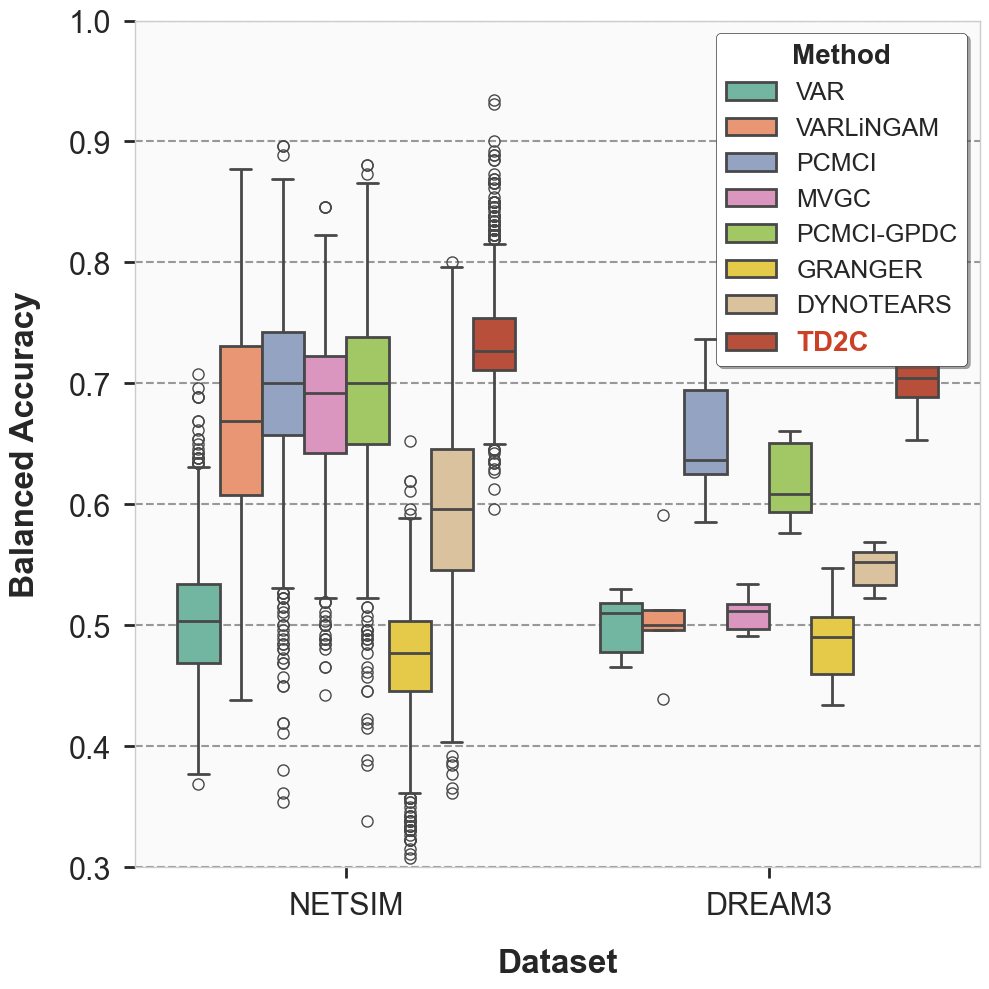

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


print("Generating enhanced poster-style vertical balanced accuracy plot...")

# Set up poster-appropriate style and figure size (vertical orientation)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 10))  # Flipped dimensions for vertical orientation

# Create custom color palette to highlight TD2C while keeping others distinct
methods = df['Method'].unique()
# Use a diverse palette for competitors, with TD2C getting the standout color
base_palette = ['#66C2A5', '#FC8D62', '#8DA0CB', '#E78AC3', '#A6D854', '#FFD92F', '#E5C494', '#B3B3B3']
colors = []
for i, method in enumerate(methods):
    if 'TD2C' in method.upper():
        colors.append('#CC4125')  # Bright orange-red for TD2C (your method)
    else:
        colors.append(base_palette[i % len(base_palette)])  # Distinct colors for competitors

# Create the vertical boxplot with enhanced spacing
boxplot = sns.boxplot(
    data=df,
    x='Dataset',  # Dataset now on x-axis
    y='Balanced Accuracy',  # Balanced Accuracy now on y-axis
    hue='Method',
    palette=colors,  # Custom palette highlighting TD2C
    ax=ax,
    orient='v',  # Explicitly set vertical orientation
    width=0.8,   # Reduced width to create more space between groups
    linewidth=2,  # Thicker box outlines for poster visibility
    fliersize=8,   # Larger outlier markers
    dodge=0.8
)

# Add extra emphasis to TD2C boxes
for i, patch in enumerate(boxplot.artists):
    # Get the method name for this box
    method_idx = i % len(methods)
    method_name = methods[method_idx]
    
    if 'TD2C' in method_name.upper():
        # Make TD2C boxes more prominent
        patch.set_linewidth(4)  # Even thicker outline
        patch.set_edgecolor('#CC4125')  # Darker edge color
        patch.set_alpha(0.9)  # Slightly more opaque
    else:
        patch.set_alpha(0.6)  # Slightly more transparent

# Enhanced styling for poster readability
ax.set_xlabel('Dataset', fontsize=24, fontweight='bold', labelpad=20) # Swapped
ax.set_ylabel('Balanced Accuracy', fontsize=24, fontweight='bold', labelpad=20) # Swapped
ax.tick_params(axis='x', labelsize=22, width=2, length=8) # Swapped
ax.tick_params(axis='y', labelsize=22, width=2, length=8) # Swapped

# x ticks DREAM3 and NETSIM (now on x-axis)
ax.set_xticks([0, 1])
ax.set_xticklabels(['NETSIM', 'DREAM3']) # Swapped to xticklabels

# Set y-axis limits for consistency (now on y-axis)
ax.set_ylim(0.3, 1) # Swapped to ylim

# Enhanced grid styling
ax.grid(axis='y', linestyle='--', alpha=0.8, linewidth=1.5, color='gray') # Changed to axis='y'
ax.set_axisbelow(True)

# Add subtle background color for better contrast
ax.set_facecolor('#fafafa')

# Enhanced legend styling for poster with TD2C emphasis
legend = ax.legend(
    title='Method',
    loc='upper right', # Adjusted for vertical layout
    fontsize=15,           # Larger font for poster
    title_fontsize=17,     # Larger title font
    frameon=True,
    fancybox=True,
    shadow=True,
    edgecolor='black',     # Border around legend
)
legend.get_title().set_fontweight('bold')

# Highlight TD2C in the legend
for text in legend.get_texts():
    if 'TD2C' in text.get_text().upper():
        text.set_fontweight('bold')
        text.set_fontsize(20)  # Slightly larger
        text.set_color('#CC4125')  # Match the box color

# Add spacing between dataset groups by adjusting subplot margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15) # Keep similar padding, might need fine-tuning

# Tight layout with padding
plt.tight_layout()

# Save high-resolution figure for poster
poster_plot_path = figures_dir + 'enhanced_poster_balanced_accuracy_vertical.png' # Updated filename
plt.savefig(poster_plot_path, dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='black', pad_inches=0.2)
plt.savefig(poster_plot_path.replace('.png', '.pdf'), bbox_inches='tight', 
           facecolor='white', edgecolor='black', pad_inches=0.2)

print(f"Enhanced vertical poster plot saved to: {poster_plot_path}")
print(f"PDF version also saved: {poster_plot_path.replace('.png', '.pdf')}")

# Display summary statistics with enhanced formatting
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
summary_stats = df.groupby(['Dataset', 'Method'])['Balanced Accuracy'].agg(['mean', 'std', 'count'])
print(summary_stats.round(4))
print("="*60)

plt.show()